# Cluster Analysis, ANN, & Text Mining: Parts 1 - Clustering
This section will cover part 1 of the rubric, which includes K-means clustering and Hierarchical clustering.

## K-Means Clustering - Rahul Gupta
We'll use K-Means clustering to group movies by similar IMDB rating, critics' score, and audience rating.

### Reading the Dataset
First, we need to load the csv dataset into a python dataframe. We will also perform a bit of preprocessing by dropping any rows with missing information.

In [49]:
import pandas as pd

df = pd.read_csv('../CSC177/imdb_dataset.csv')

# Remove missing values
data = df.dropna()

data.head()

,Unnamed: 0,title,title_type,genre,runtime,mpaa_rating,studio,thtr_rel_year,thtr_rel_month,thtr_rel_day,...,best_dir_win,top200_box,director,actor1,actor2,actor3,actor4,actor5,imdb_url,rt_url
0,1,Filly Brown,Feature Film,Drama,80.0,R,Indomina Media Inc.,2013,4,19,...,no,no,Michael D. Olmos,Gina Rodriguez,Jenni Rivera,Lou Diamond Phillips,Emilio Rivera,Joseph Julian Soria,http://www.imdb.com/title/tt1869425/,//www.rottentomatoes.com/m/filly_brown_2012/
1,2,The Dish,Feature Film,Drama,101.0,PG-13,Warner Bros. Pictures,2001,3,14,...,no,no,Rob Sitch,Sam Neill,Kevin Harrington,Patrick Warburton,Tom Long,Genevieve Mooy,http://www.imdb.com/title/tt0205873/,//www.rottentomatoes.com/m/dish/
2,3,Waiting for Guffman,Feature Film,Comedy,84.0,R,Sony Pictures Classics,1996,8,21,...,no,no,Christopher Guest,Christopher Guest,Catherine O'Hara,Parker Posey,Eugene Levy,Bob Balaban,http://www.imdb.com/title/tt0118111/,//www.rottentomatoes.com/m/waiting_for_guffman/
3,4,The Age of Innocence,Feature Film,Drama,139.0,PG,Columbia Pictures,1993,10,1,...,yes,no,Martin Scorsese,Daniel Day-Lewis,Michelle Pfeiffer,Winona Ryder,Richard E. Grant,Alec McCowen,http://www.imdb.com/title/tt0106226/,//www.rottentomatoes.com/m/age_of_innocence/
4,5,Malevolence,Feature Film,Horror,90.0,R,Anchor Bay Entertainment,2004,9,10,...,no,no,Stevan Mena,Samantha Dark,R. Brandon Johnson,Brandon Johnson,Heather Magee,Richard Glover,http://www.imdb.com/title/tt0388230/,//www.rottentomatoes.com/m/10004684-malevolence/


### Finding Number of Clusters: Elbow Method
Using the elbow method, we can figure out what the optimal number of clusters should be. In this case, it looks like the optimal number would be either 2 or 3 clusters, since those are the points in the graph where the line begins to curve. For the rest of the code, I'll be using 3 clusters.

In [50]:
# Use this to get around threads warning!

import os
os.environ["OMP_NUM_THREADS"] = '2'

Text(0, 0.5, 'SSE')

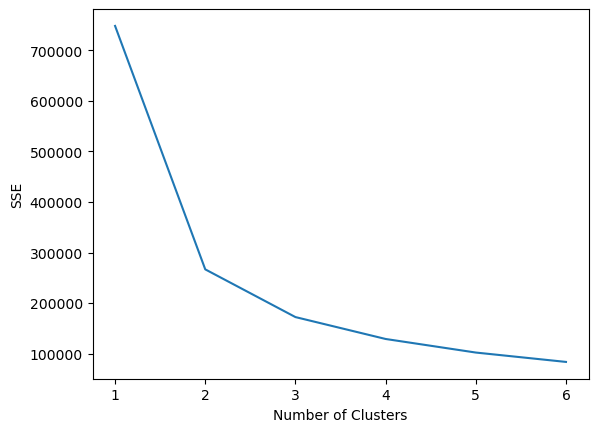

In [51]:
from sklearn import cluster
import matplotlib.pyplot as plt
%matplotlib inline

k_means_data = data[['imdb_rating', 'critics_score', 'audience_score']]

numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k, n_init=10)
    k_means.fit(k_means_data)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

### Training & Testing Data Split
We also need to split the data into training and testing dataframes, so we can train the K-Means model and then test it.

In [52]:
from sklearn.model_selection import train_test_split

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(data, data.title, test_size=0.2, random_state=42)

# Recombine into dataframes
train_df = pd.DataFrame(X_train, columns=data.columns)
test_df = pd.DataFrame(X_test, columns=data.columns)


# Drop all columns except IMDB rating, critic score, and audience score
train_data = train_df[['imdb_rating', 'critics_score', 'audience_score']]
test_data = test_df[['imdb_rating', 'critics_score', 'audience_score']]

### Training K-Means
Now that the data has been processed and split into traning and testing, we can give the training data to K-Means clustering algorithm.

In [53]:
# Give training data to K-Means
k_means = cluster.KMeans(n_clusters=3, max_iter=50, random_state=1, n_init = 10)
k_means.fit(train_data) 
labels = k_means.labels_

pd.DataFrame(labels, index=train_df['title'], columns=['Cluster ID']).head()

,Cluster ID
title,
Cold Creek Manor,1
Memento,0
Where the Heart Is,1
Amityville II: The Possession,1
Flesh And Bone,2


### Centroids
Now that the K-Means model has been trained, we can view what the centroid values look like. The centroid is the mean of the data points assigned to that particular cluster. Since we have 3 clusters, we will end up with 3 centroids.

In [54]:
centroids = k_means.cluster_centers_
pd.DataFrame(centroids,columns=train_data.columns)

,imdb_rating,critics_score,audience_score
0,7.374468,85.718085,80.372340
1,5.335417,20.576389,42.527778
2,6.428221,56.822086,57.803681


### Testing K-Means on Testing Data
Now that we have fitted the K-Means model, we can give it testing data to see how the data will be grouped.

In [55]:
import numpy as np

labels = k_means.predict(test_data)
labels = labels.reshape(-1, 1)

movie_titles = np.array(test_df.title).reshape(-1, 1)

num_data = np.concatenate((movie_titles, test_data, labels), axis=1)

cols = test_data.columns.tolist() + ['Cluster ID']
predicted_data = pd.DataFrame(num_data, columns=['title'] + cols)

predicted_data.head()

,title,imdb_rating,critics_score,audience_score,Cluster ID
0,Seven Pounds,7.7,27.0,75.0,1
1,Saving Face,7.6,87.0,88.0,0
2,Warrior,8.2,82.0,92.0,0
3,The Sure Thing,7.0,87.0,79.0,0
4,Held Up,5.1,17.0,43.0,1


### Cluster Observations
We can visualize the cluster and make observations from it. K-Means may not be the best fit for this particular relationship of attributes, since the clusters are not spherical and seem to follow a more linear pattern. However, we can see that the centroids seem to be in the center of each of their respective clusters, which is to be expected. 

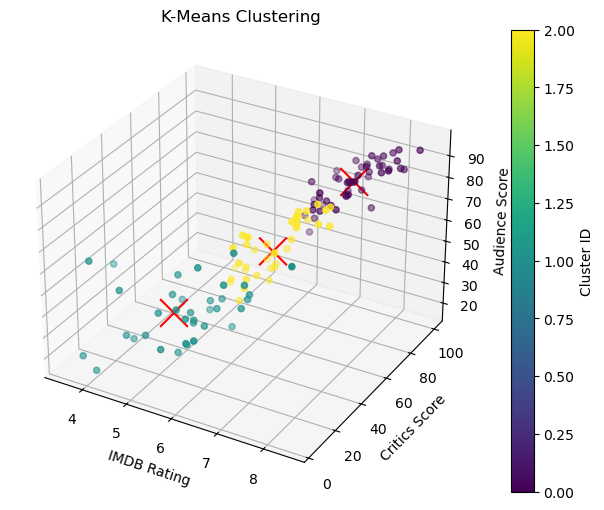

In [56]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points, with each cluster assigned a different color
scatter = ax.scatter(X_test['imdb_rating'], X_test['critics_score'], X_test['audience_score'], c=labels, cmap='viridis')
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x', s=400, c='red', label='Centroids', alpha=1.0)

# Set labels and title
ax.set_xlabel('IMDB Rating')
ax.set_ylabel('Critics Score')
ax.set_zlabel('Audience Score')
ax.set_title('K-Means Clustering')

plt.colorbar(scatter, label='Cluster ID')

plt.show()

## Hierarchal Clustering - Penny Herrera

### Single Link

In [64]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(linkage="single", distance_threshold = 7, n_clusters=None)
     
model.fit(k_means_data)

AgglomerativeClustering(distance_threshold=7, linkage='single', n_clusters=None)

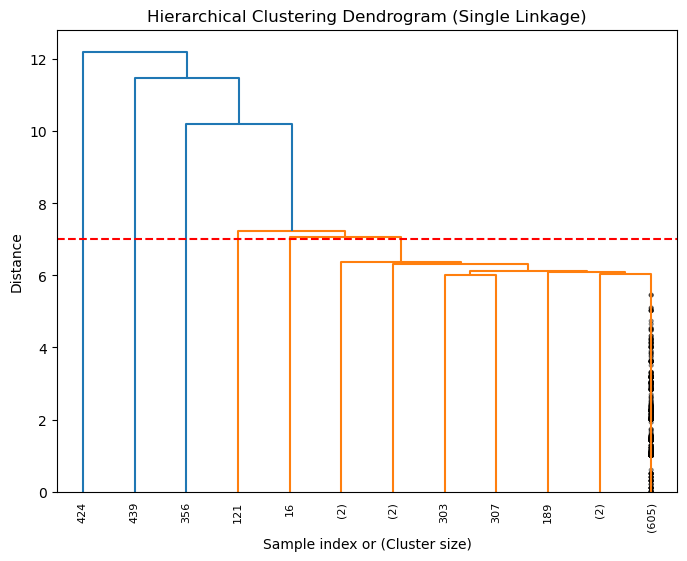

In [65]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

#convert DataFrame to a NumPy array
A = k_means_data.values
#generate linkage matrix using single linkage
B = linkage(A, 'single')

#plot dendrogram
plt.figure(figsize=(8, 6))
plt.title('Hierarchical Clustering Dendrogram (Single Linkage)')
plt.xlabel('Sample index or (Cluster size)')
plt.ylabel('Distance')
dendrogram(
    B,
    leaf_rotation=90.,  
    leaf_font_size=8.,  
    truncate_mode='lastp',  
    p=12,  
    show_contracted=True  
)
plt.axhline(y=7, color='r', linestyle='--')
plt.show()

### Complete Link

In [66]:
model = AgglomerativeClustering(linkage="complete",
                                distance_threshold = 7,
                                n_clusters=None)
     

model.fit(k_means_data)

AgglomerativeClustering(distance_threshold=7, linkage='complete',
                        n_clusters=None)

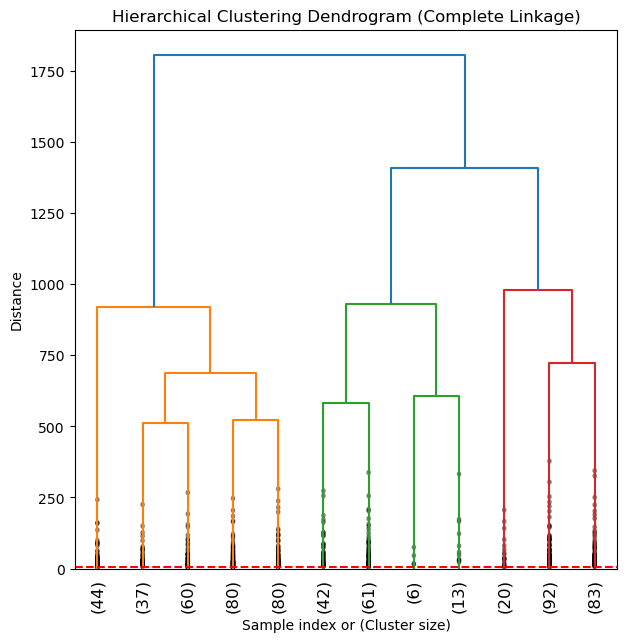

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import complete, dendrogram

#computes complete linkage matrix
C = complete(B)

def complete_dendrogram(C, max_d=7, **kwargs):
    #create dendrogram
    plt.figure(figsize=(7, 7))
    plt.title("Hierarchical Clustering Dendrogram (Complete Linkage)")
    dendrogram(C, **kwargs)
    plt.axhline(y=max_d, color='r', linestyle='--')
    plt.xlabel('Sample index or (Cluster size)')
    plt.ylabel('Distance')
    plt.show()

#plot dendrogram
complete_dendrogram(C, max_d=7, truncate_mode='lastp', p=12, leaf_rotation=90, leaf_font_size=12, show_contracted=True)



### Average Link

In [68]:
model = AgglomerativeClustering(linkage="average",
                                distance_threshold = 7,
                                n_clusters=None)
     

model.fit(k_means_data)

AgglomerativeClustering(distance_threshold=7, linkage='average',
                        n_clusters=None)

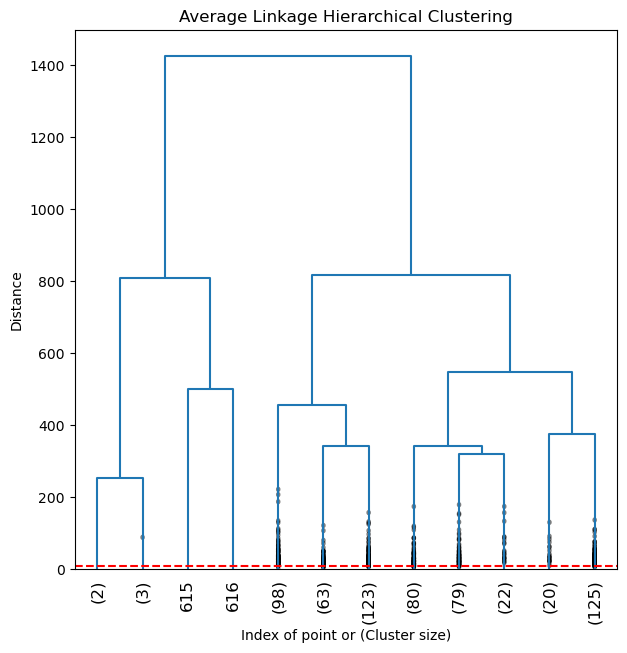

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import average, dendrogram

#computes average linkage matrix
linkage_matrix = average(C)

def average_dendrogram(linkage_matrix, max_distance=7, **kwargs):
    #create dendrogram
    plt.figure(figsize=(7, 7))
    plt.title("Average Linkage Hierarchical Clustering")
    dendrogram(
        linkage_matrix,
        color_threshold=max_distance, 
        **kwargs
    )

    plt.axhline(y=max_distance, color='r', linestyle='--')
    plt.xlabel('Index of point or (Cluster size)')
    plt.ylabel('Distance')
    plt.show()

#plot & customize dendrogram
average_dendrogram(
    linkage_matrix, 
    max_distance=7, 
    truncate_mode='lastp', 
    p=12, 
    leaf_rotation=90, 
    leaf_font_size=12, 
    show_contracted=True
)

     